Build feature and output arrays (identical to MLP.ipynb)

In [66]:
import numpy as np
import pandas as pd
import json

# Listen für alle Daten
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# JSON-Datei laden
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Daten sammeln
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

# Alle Werte auf zwei Nachkommastellen runden
all_hub_heights = np.round(all_hub_heights, decimals=2)
all_capacities = np.round(all_capacities, decimals=2)

# NaN-Werte in Turbinentypen durch eindeutige Namen ersetzen
nan_counter = 1
for idx, turbine in enumerate(all_turbine_types):
    if pd.isna(turbine):
        all_turbine_types[idx] = f"nan{nan_counter}"
        nan_counter += 1

# convert E92/2350 format to E-92/2350 format
all_turbine_types = [f"E-{turbine[1:]}" if turbine.startswith("E") and not turbine.startswith("E-") else turbine for turbine in all_turbine_types]

# Datumsformat korrigieren
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# In datetime konvertieren
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# Berechnung des Alters
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# Kombinierte Features und Outputs erstellen
combined_features = []
output = []

# Daten in Feature-Arrays konvertieren
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Wiederholungen für allgemeine Features
    turbine_type_repeated = np.full((num_rows, 1), all_turbine_types[idx])
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extrahiere Produktionswerte und Windgeschwindigkeiten
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    wind_speeds = np.round(wind_speeds, decimals=2)

    import pandas as pd

    # Kombinieren in DataFrame, ohne dtype-Konvertierung (bei numpy arrays muss niedrigster gemeinsamer Datentyp gewählt werden, was string wäre wegen turbine_type_repeated)
    combined_chunk = pd.concat([
        pd.DataFrame(turbine_type_repeated, columns=["Turbine_Type"]),
        pd.DataFrame(hub_height_repeated, columns=["Hub_Height"]),
        pd.DataFrame(capacity_repeated, columns=["Capacity"]),
        pd.DataFrame(age_repeated, columns=["Age"]),
        pd.DataFrame(wind_speeds, columns=["Wind_Speed"])
    ], axis=1)

    # Füge die Daten hinzu
    combined_features.append(combined_chunk)
    output.append(production_values)

# Kombinieren aller Datensätze in einem großen Array
combined_features_raw = np.vstack(combined_features)
output = np.vstack(output)
output_raw = np.round(output, decimals=2)

Extract subset of data for setup of benchmarking test (identical to MLP.ipynb)

In [79]:
import numpy as np

num_samples = 100000
random_indices = np.random.choice(combined_features_raw.shape[0], num_samples, replace=False)

combined_features_subset = combined_features_raw[random_indices].copy()
output_subset = output_raw[random_indices].copy()

Extract relevant features

In [142]:
wind_speeds_data = combined_features_subset[:, -1]
capacities = combined_features_subset[:, -3]
turbine_types = combined_features_subset[:, 0]
actual_power_output = output_subset.flatten()

wind_speed_max = 25

<h1>1. One representative power curve

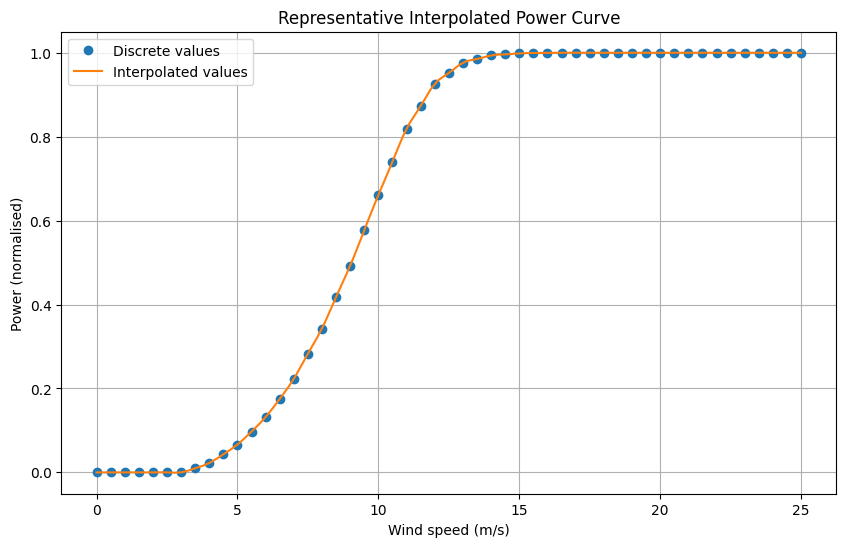

In [117]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Definiere die Power Curve (Windgeschwindigkeit und Leistung)
wind_speeds = np.arange(0, 25.5, 0.5)  # Windgeschwindigkeiten
power_output = [0]*7 + [35, 80, 155, 238, 350, 474, 630, 802, 1018, 1234, 1504, 1773, 2076, 2379, 2664, 2948, 3141, 3334, 3425, 3515, 3546, 3577, 3586, 3594, 3598, 3599] + [3600]*18  # Leistung
max_cap = 3600
power_output_norm = [x / max_cap for x in power_output]
wind_speed_max = 25

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(wind_speeds, power_output_norm, kind='cubic', fill_value="extrapolate")

# Beispiel für Interpolation: Bestimme Werte für feinere Windgeschwindigkeiten
fine_wind_speeds = np.linspace(0, 25, 100)  # Feinere Windgeschwindigkeiten
interpolated_power_output = interpolation_function(fine_wind_speeds)

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(wind_speeds, power_output_norm, 'o', label='Discrete values')
plt.plot(fine_wind_speeds, interpolated_power_output, '-', label='Interpolated values')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (normalised)')
plt.title('Representative Interpolated Power Curve')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [136]:
# Ensure wind_speeds_data is a numeric array: convert float elements to np.float64 elements
wind_speeds_data = wind_speeds_data.astype(float)

predicted_power_output = interpolation_function(wind_speeds_data) * capacities

<h1>2. Power curves from windpowerlib (for all supported turbine types in feature vector)

c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\windpowerlib\data.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


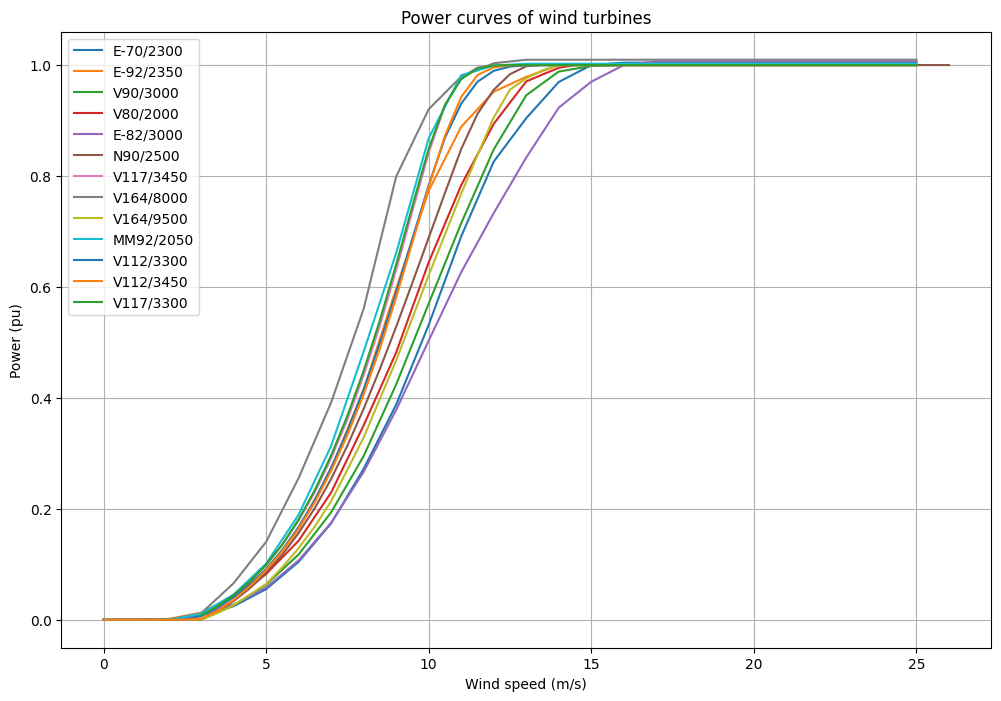

In [143]:
from windpowerlib import WindTurbine
from windpowerlib import data as wt
import matplotlib.pyplot as plt

# Annahme: turbine_types_set ist bereits definiert und enthält die zu prüfenden Turbinen-Typen
turbine_types_set = set(all_turbine_types)

# Turbinendaten abrufen
turbine_data = wt.get_turbine_types(print_out=False)

# Liste zum Speichern der erstellten WindTurbine-Objekte
wind_turbines = []

# Schleife über alle Turbinentypen im Set
for turbine_type in turbine_types_set:
    # Prüfen, ob der Turbinentyp in den Daten existiert
    if turbine_type in turbine_data['turbine_type'].values:
        
        hub_height = 100  # Nabenhöhe irrelevant für power curve
        
        # Definition des WindTurbine-Dictionaries
        turbine_dict = {
            'turbine_type': turbine_type,
            'hub_height': hub_height
        }
        
        # Dynamische Erstellung des WindTurbine-Objekts
        wind_turbine = WindTurbine(**turbine_dict)
        
        # Hinzufügen zur Liste
        wind_turbines.append(wind_turbine)

# Plot der Power Curves
plt.figure(figsize=(12, 8))
for turbine in wind_turbines:
    if turbine.power_curve is not None:
        plt.plot(turbine.power_curve['wind_speed'], turbine.power_curve['value'] / turbine.nominal_power,
                 label=turbine.turbine_type)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Power curves of wind turbines')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [144]:
from scipy.interpolate import interp1d

# after analysis of plot
default_turbine = next(turbine for turbine in wind_turbines if turbine.turbine_type == "N90/2500")
wind_speed_max = 25

predicted_power_output = []

# Iteration über alle Datenpunkte
for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

    # Suche die passende Turbine
    turbine = next((turbine for turbine in wind_turbines if turbine.turbine_type == turbine_type), default_turbine)

    # Erstelle eine Interpolationsfunktion für die Power Curve dieser Turbine
    interpolation_function = interp1d(
        turbine.power_curve['wind_speed'],
        turbine.power_curve['value'] / turbine.nominal_power,
        kind='cubic',
        fill_value=0,  # Setze Werte außerhalb des Bereichs auf 0
        bounds_error=False
    )
    
    # Vorhergesagten Wert berechnen
    predicted_power_output.append(interpolation_function(wind_speed) * capacity)

predicted_power_output = np.array(predicted_power_output)

# Setze vorhergesagte Leistung auf 0 für Windgeschwindigkeiten über wind_speed_max
predicted_power_output[wind_speeds_data > wind_speed_max] = 0

<h1>3. Results

In [145]:
import torch

# Ensure the arrays are of type float
predicted_power_output = predicted_power_output.astype(float)
actual_power_output = actual_power_output.astype(float)

predicted_torch = torch.tensor(predicted_power_output, dtype=torch.float32)
actual_torch = torch.tensor(actual_power_output, dtype=torch.float32)

# Berechne den Huber Loss
huber_loss_fn = torch.nn.HuberLoss()
huber_loss_value = huber_loss_fn(predicted_torch, actual_torch).item()
print(f"Huber Loss: {huber_loss_value:.2f}")

# Berechne den MAE Loss
mae_loss_fn = torch.nn.L1Loss()  # L1 Loss entspricht MAE
mae_loss_value = mae_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Absolute Error (MAE): {mae_loss_value:.2f} MW")

# Berechne den MSE Loss
mse_loss_fn = torch.nn.MSELoss()
mse_loss_value = mse_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Squared Error (MSE): {mse_loss_value:.2f} MW²")

Huber Loss: 27.47
Mean Absolute Error (MAE): 27.94 MW
Mean Squared Error (MSE): 2978.67 MW²


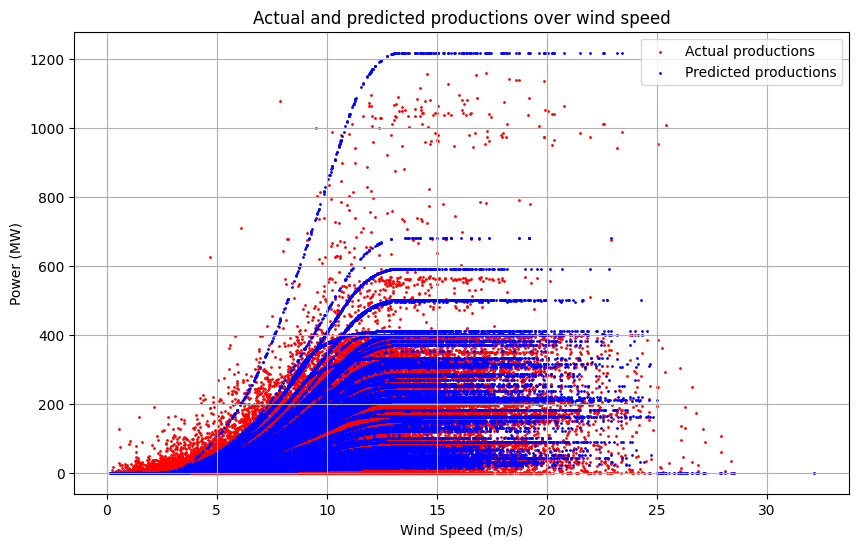

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, actual_power_output, color='red', s=1, label='Actual productions')
plt.scatter(wind_speeds_data, predicted_power_output, color='blue', s=1, label='Predicted productions')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted productions over wind speed')
plt.legend()
plt.grid(True)
plt.show()

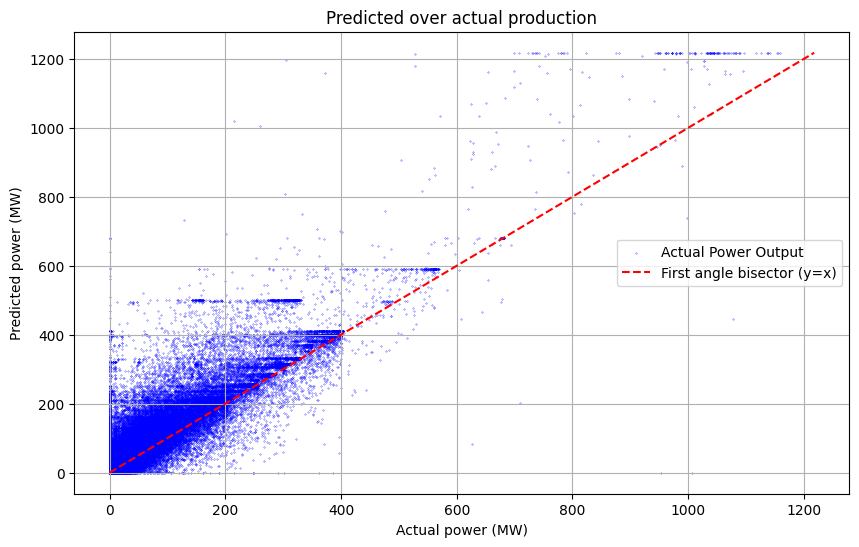

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(actual_power_output, predicted_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Actual power (MW)')
plt.ylabel('Predicted power (MW)')
plt.title('Predicted over actual production')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_7420\4000434538.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


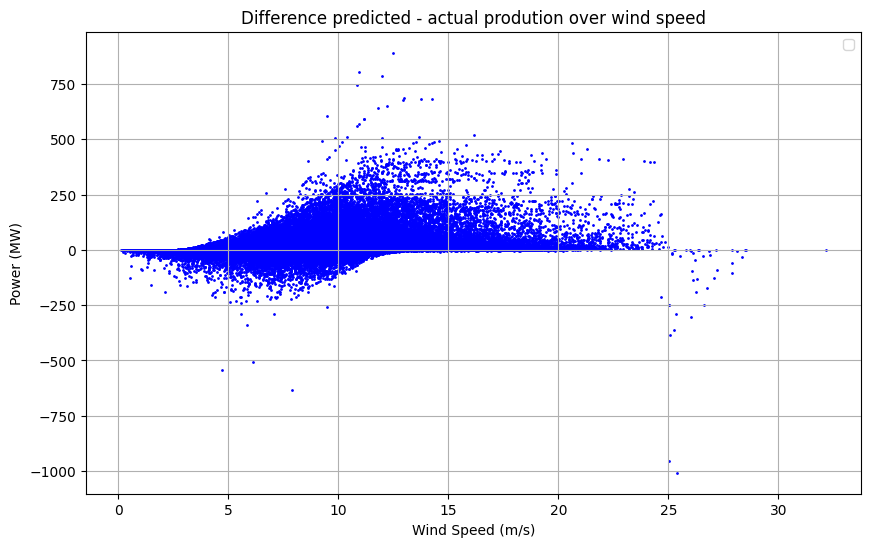

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, predicted_power_output-actual_power_output, color='blue', s=1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Difference predicted - actual prodution over wind speed')
plt.legend()
plt.grid(True)
plt.show()

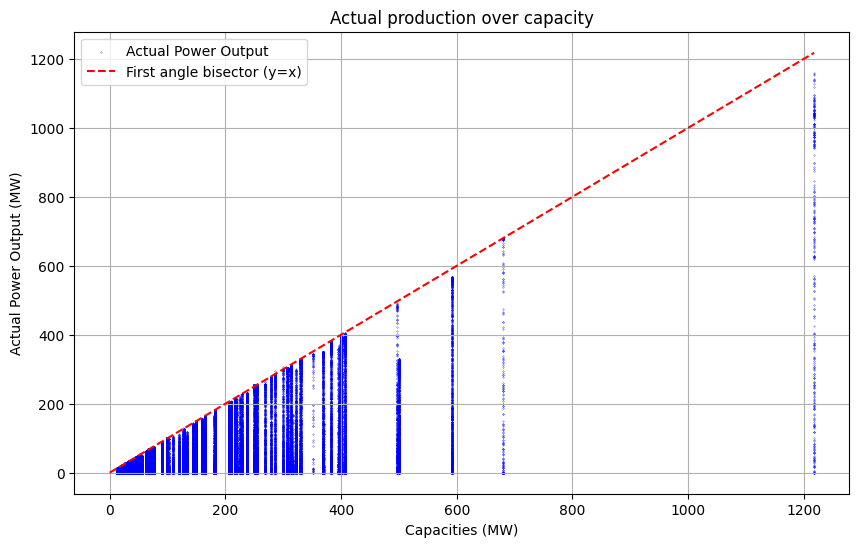

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(capacities, actual_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Capacities (MW)')
plt.ylabel('Actual Power Output (MW)')
plt.title('Actual production over capacity')
plt.legend()
plt.grid(True)
plt.show()